In [28]:
# the first thing I needed to do for this was get the best performance for ice mask I could 
# I tuned the model, this time using the dataset with the engineered features 

import pandas as pd 
import numpy as np 

df = pd.read_csv('../data/AIS_data/EF_ice_mask_for_sequential.csv')

df = df[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist', 'temp_diff',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity', 
                                     'ice_thickness', 'ice_mask']]


#removing corners where ocean value is just the fill and the two 0 targets

tolerance = 1e+30
df = df[(df['ocean_temp'] < (9.969210e+36 - tolerance))]


#removing rows where theres the random 0 for ice mask (its only like two)
df = df[df['ice_mask']>0] 

#imputing ice velocity to -1 so it can be predicted as a number
df.fillna(value = -1, inplace = True)

df.head()


#SO: this df now has the engineered features (tailored for ice mask prediction), ice velocity = -1 where no ice
# and the corners removed where there is fill values for ocen temperature. 

def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def scale_entire_df (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df


def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)

In [12]:
# I will now use that df to tune for predicting ice mask -> being sure to remove ice velocity and thickness

ice_mask = df.copy()
ice_mask.drop(columns = ['ice_velocity', 'ice_thickness'], inplace = True)

ice_mask.head()



,x-axis,y-axis,precipitation,air_temp,ocean_temp,dist,temp_diff,precip_roll,air_roll,ocean_roll,ice_mask
14,-1337600,3040000,546.317932,266.901917,272.842255,3.321261e+06,5.940338,543.675851,266.719133,1.510486e+36,4
15,-1216000,3040000,525.335876,266.538788,272.781281,3.274180e+06,6.242493,534.202270,266.287153,1.057340e+36,4
16,-1094400,3040000,515.289246,266.182617,272.733276,3.230992e+06,6.550659,523.161323,265.918555,6.041945e+35,4
17,-972800,3040000,506.943146,265.830536,272.698181,3.191855e+06,6.867645,512.176727,265.608407,3.020973e+35,4
18,-851200,3040000,501.923645,265.492554,272.672577,3.156920e+06,7.180023,501.798299,265.354218,1.510486e+35,4


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


def doPolySVCWithTuning(preprocessed_df, seed, n_runs):
    best_params = []
    
    X = preprocessed_df.iloc[:, :-1]
    y = preprocessed_df.iloc[:, -1]
        
        
    for i in range(n_runs):
        randomState = i * seed
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState
                                                           , stratify = y)

        #define the model 
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')

        # Set up the grid of parameters to search
        param_grid = {
            'C': [1, 10, 100, 1000],  # Regularization parameter
            'degree': [2, 3, 4, 5],  # Degree of the polynomial kernel
            'gamma': ['scale', 'auto'],  # Kernel coefficient
            'coef0': [1, 5, 10, 15] 
        }
            
        # Set up the grid search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)
        
        #store the best params from this run 
        best_params.append(grid_search.cv_results_['params'][grid_search.best_index_])

    print("Best Parameters per Run:", best_params)

    return best_params, param_grid
        
seed = 101
scaled_df = scale(ice_mask)
n_runs = 30
best_params, param_grid = doPolySVCWithTuning(scaled_df, seed, n_runs)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 3

param counts
C
1        2
10       9
100     10
1000     9
Name: count, dtype: int64


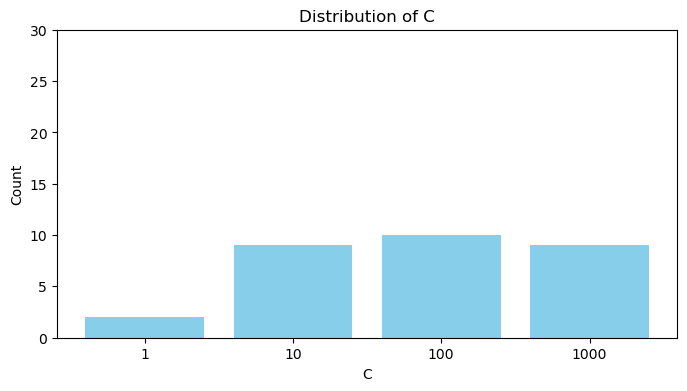

param counts
degree
2     0
3     1
4     4
5    25
Name: count, dtype: int64


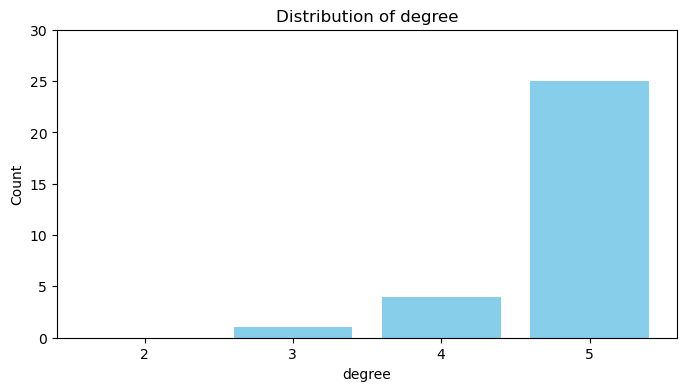

param counts
gamma
scale    30
auto      0
Name: count, dtype: int64


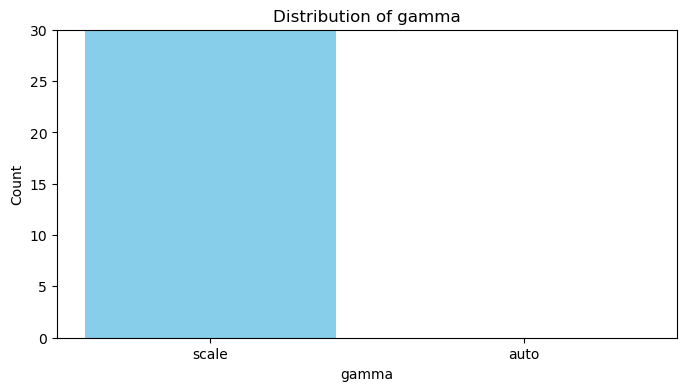

param counts
coef0
1     8
5     6
10    8
15    8
Name: count, dtype: int64


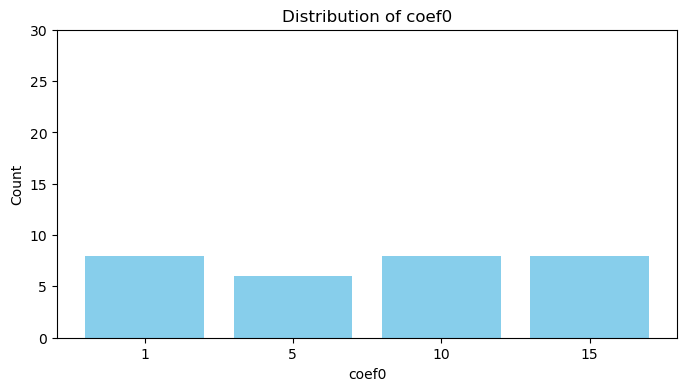

In [15]:
import matplotlib.pyplot as plt

def visualize_parameter_distribution_no_grid(param_dict, param_grid, n_runs):
    # Convert 'None' to string 'None' for 'max_depth'
    for d in param_dict:
        if 'max_depth' in d and d['max_depth'] is None:
            d['max_depth'] = 'None'
    
    # Convert the dictionary to a DataFrame for easier manipulation
    df = pd.DataFrame(param_dict)

    # Loop through each parameter in the grid and create separate bar charts
    for param, values in param_grid.items():
        
        if param == "max_depth":
            values = ['None' if v is None else v for v in values]
            
        
        # Count the occurrences of each parameter value in the dictionary
        param_counts = df[param].value_counts().reindex(values, fill_value=0)
        print("param counts")
        print(param_counts)
        # Plot the bar chart for the parameter
        plt.figure(figsize=(8, 4))
        plt.bar(param_counts.index.astype(str), param_counts.values, color='skyblue')
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.ylim(0, n_runs)  # Set y-axis limit to n_runs
        plt.show()

# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(best_params, param_grid, n_runs)

In [17]:
def doTunedPolySVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        print(i)
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced', 
                   degree = 5, gamma = 'scale', C = 1.0, coef0 = 10)
        model.fit(X_train, y_train)
        
        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
seed = 101
scaled_df = scale(ice_mask)
n_runs = 30
doTunedPolySVC(scaled_df, seed, n_runs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Average Training Accuracy: 0.983, Std: 0.003
Training Category Metrics:
  grounded_ice: Avg: 0.957, Std: 0.008
  floating_ice: Avg: 1.000, Std: 0.000
  open_ocean: Avg: 0.999, Std: 0.001

Average Test Accuracy: 0.946, Std: 0.007
Test Category Metrics:
  grounded_ice: Avg: 0.920, Std: 0.015
  floating_ice: Avg: 0.669, Std: 0.091
  open_ocean: Avg: 0.980, Std: 0.008


In [33]:
def predict_ice_mask(preprocessed_df, randomState): 
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        
        #split into training and test 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState, stratify = y)

        #then remove the ice velocity from both xy train and test, but keep aside 
        X_train_velocity = X_train['ice_velocity']
        X_train.drop(columns = ['ice_velocity'], inplace = True)
        X_test_velocity = X_test['ice_velocity']
        X_test.drop(columns = ['ice_velocity'], inplace = True)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced', 
                   degree = 5, gamma = 'scale', C = 1.0, coef0 = 10)
        model.fit(X_train, y_train)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        
        # Test data evaluation
        y_test_predicted = model.predict(X_test)
        
        #adding the data back together
        X_train['predicted_ice_mask'] = y_train_predicted
        X_train['ice_velocity'] = X_train_velocity
        X_test['predicted_ice_mask'] = y_test_predicted
        X_test['ice_velocity'] = X_test_velocity
        combined_df = pd.concat([X_train, X_test], ignore_index=True)
#         combined_df = combined_df[combined_df['predicted_ice_mask']<4]
#         combined_df = combined_df[combined_df['predicted_ice_mask']>2]

        return combined_df
    

seed = 101
#removing ice thickness for now, as I am only looking at ice velocity 
preprocessed_df = df.drop(columns = ['ice_thickness'], inplace = False) 
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
ice_velocity_pred_IM = predict_ice_mask(scaled_preprocessed_df, seed)
ice_velocity_pred_IM.head(20)
ice_velocity_pred_IM['predicted_ice_mask'].nunique()



3

In [56]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest_with_IM(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = seed*i
        df = predict_ice_mask(preprocessed_df, randomState)
        
        #deleting engineered features as they showed to be worse for predicting IV than without in previous runs 
        df.drop(columns = ['precip_roll', 'air_roll', 'ocean_roll', 'temp_diff', 'dist'], inplace = True)

        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=randomState, 
                                                            stratify = X['predicted_ice_mask'])

        model = RandomForestRegressor(random_state=randomState)
        model.fit(X_train, y_train)
        
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
#         print("X TEST")
#         print(X_test)
#         print ("Y TEST")
#         print(y_test)
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

seed = 101
preprocessed_df = df.drop(columns = ['ice_thickness'], inplace = False)
#uncomment for getting results for Trimmed OF+PIM
preprocessed_df = preprocessed_df[preprocessed_df['ice_velocity']>-1.0] 
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df) 
IV_importances, IV_std_importances = doRandomForest_with_IM(scaled_preprocessed_df, seed, 
                                                    30, 'ice_velocity', preprocessed_df)

Training Average Score: 0.8756, Std Dev: 0.0146
Training Average RMSE: 105.32, Std Dev: 12.21


Test Average Score: 0.1394, Std Dev: 0.1741
Test Average RMSE: 281.51, Std Dev: 55.68


Average Importances: [0.09627944 0.12218529 0.24577038 0.29874839 0.14532427 0.09169223]
Importances Std Dev: [0.01955105 0.02488068 0.05502042 0.06452344 0.03203826 0.02505962]


 Train-Test (Difference): 0.7362


In [42]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState)
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)


    return avg_importances, std_importances

In [54]:
#doing a basic RF to compare metrics in final report 

ice_velocity = pd.read_csv('../data/ice_velocity.csv')
trimmed_ice_velocity = pd.read_csv('../data/trimmed_ice_velocity.csv')
# trimmed_ice_velocity = ice_velocity[ice_velocity['ice_velocity']!=-1]

scaled_velocity = scale_entire_df(ice_velocity)
scaled_trimmed_velocity = scale_entire_df(trimmed_ice_velocity)



seed = 101
print("ice velocity whole domain below")
IV_importances, IV_std = doRandomForest(scaled_velocity, seed, 30, 'ice_velocity', ice_velocity)
print('\n\ntrimmed ice velocity below')
TIV_importances, TIV_std = doRandomForest(scaled_trimmed_velocity, seed, 30, 'ice_velocity', trimmed_ice_velocity)



ice velocity whole domain below
Training Average Score: 0.8466, Std Dev: 0.0128
Training Average RMSE: 79.94, Std Dev: 7.30


Test Average Score: -0.1711, Std Dev: 0.2552
Test Average RMSE: 198.79, Std Dev: 32.56


Average Importances: [0.09599419 0.08645278 0.36142585 0.27630532 0.17982186]
Importances Std Dev: [0.01540304 0.01802917 0.03771118 0.04812352 0.02951412]


trimmed ice velocity below
Training Average Score: 0.8707, Std Dev: 0.0136
Training Average RMSE: 109.24, Std Dev: 8.75


Test Average Score: 0.0014, Std Dev: 0.2240
Test Average RMSE: 295.44, Std Dev: 42.79


Average Importances: [0.08589561 0.12249242 0.22177165 0.37890984 0.19093048]
Importances Std Dev: [0.01213408 0.02661108 0.04496875 0.05545489 0.02851606]
